<div class="alert alert-warning" role="alert"; style="border:groove rgb(57,136,235) 5px; padding: 40px">


<h1 align="center", style="margin-bottom: -10px">Предсказание коэффициента восстановления золота из золотосодержащей руды<a class="tocSkip"></h1>
<h4 align="center", style="margin-bottom: 60px">Сборный проект №2, Яндекс Практикум <a class="tocSkip"> </h4>
<h4 align="right", style="margin-bottom: -15px">Исполнитель: Воронин Артём<a class="tocSkip"></h4> 

<h1 align="center">Описание проекта</h1>
<p style="margin-bottom: 30px"></p>
Компания «Цифры», разрабатывающая решения для эффективной работы промышленных предприятий, предоставила реальные данные с параметрами добычи и очистки золотосодержащей руды с одного из месторождений. Необходимо на основании этих данных подготовить прототип модели машинного обучения для предсказния коэффициента восстановления золота из золотосодержащей руды. Это поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.
<p style="margin-bottom: 50px"></p>

<h2> Описание данных:  <span class="tocSkip"></span></h2>

Данные состоят из 3 файлов:

- `gold_recovery_train_new.csv` - тренировочные данные;   
- `gold_recovery_test_new.csv` - тестовые данные;     
- `gold_recovery_full_new.csv` - полные сырые данные. 

## Подготовка данных

In [1]:
# установка пакетов

!pip install pandas_profiling --quiet --disable-pip-version-check

In [2]:
# импорт библиотек

import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import phik
from phik.report import plot_correlation_matrix
from phik import report

from tqdm import tqdm
from copy import deepcopy

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import *
from sklearn.dummy import DummyRegressor

/tmp/ipykernel_233/3380469550.py:4: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


### Открытие файлов и предварительный обзор

In [3]:
# загрузка данных

def data_load(name):
    
    try:
        data = pd.read_csv(f'/datasets/{name}.csv')
        return data    
    except:
        try:
            data = pd.read_csv(f'https://code.s3.yandex.net/datasets/{name}.csv')
            return data
        except:  
            print(f'Ошибка месторасположения csv-файла "{name}"')
    

    
train, test, full = [data_load(i) for i in [ 'gold_recovery_train_new',
                                             'gold_recovery_test_new',
                                             'gold_recovery_full_new'  ]
                    ]

#### Обучающая выборка

In [4]:
# pandas_profiling.ProfileReport(train, minimal=True)

In [5]:
train.info()
print()
display(train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


#### Тестовая выборка

In [6]:
test.info()
print()
display(test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


#### Полная выборка

In [7]:
full.info()
print()
display(full.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


**Вывод:** Данные содержат 87 признаков. Пропуски имеются во всех 3 датасетах (более детально рассмотрим ниже). Предположительно train и test это выборки из full датасета.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:  </b> 
    
С данными познакомились, проведен первичный аналитический осмотр!) Полученная информация поможет нам в дальнейшем с предобработкой данных.

### Проверка расчета эффективности обогащения

**Эффективность** обогащения рассчитывается по формуле:

Recovery = (C * (F - T)) / (F * (C - T)) *100%  

где:  
C — доля золота в концентрате после флотации/очистки `ougher.output.concentrate_au`;  

F — доля золота в сырье/концентрате до флотации/очистки `rougher.input.feed_au`;  

T — доля золота в отвальных хвостах после флотации/очистки `rougher.output.tail_au`.  


In [8]:
c = train['rougher.output.concentrate_au']
f = train['rougher.input.feed_au']
t = train['rougher.output.tail_au']

recovery_check = (c * (f - t)) / (f * (c - t)) * 100

mean_absolute_error(train['rougher.output.recovery'], recovery_check)

9.73512347450521e-15

**Вывод**: Значение средней абсолютной ошибки ничтожно мало. Это говорит о том, что эфективность обогащения расчитана правильно.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Твое расссчитанное значение `MAE` верно)

### Анализ признаков тестовой выборки


In [9]:
set(train.columns) - set(test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

**Вывод:** 
В тестовой выборке отсутствуют следующие признаки:

+ `final.output` 
+ `primary_cleaner.output`
+ `secondary_cleaner.output`
+ `rougher.output` 
+ `rougher.calculation`   
 
Признаки "output" являются параметрами продукта. Т.е. в выборке отсутствуют выходные данные после каждого этапа обработки, а так же расчетные хар-ки "calculation". Два из них нам по заданию нужно будет спрогнозировать - `rougher.output.recovery` и `final.output.recovery`.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
    
Все верно, в тестовой выборке недоступны некоторые расчетные (calculation) и выходные (output) характеристики процесса, ведь их невозможно получить либо замерить во время выполнения технологического процесса.

### Предобработка данных

#### Обучающая выборка

**Дубликаты**

In [10]:
train.duplicated().sum()

0

Явных дубликатов нет. Посмотрим есть ли дубликаты записей по времени:

In [11]:
train.duplicated(subset='date').sum()

0

Дубликатов объектов по времени тоже нет.

**Пропуски**

In [12]:
train.isna().sum().sum()

4100

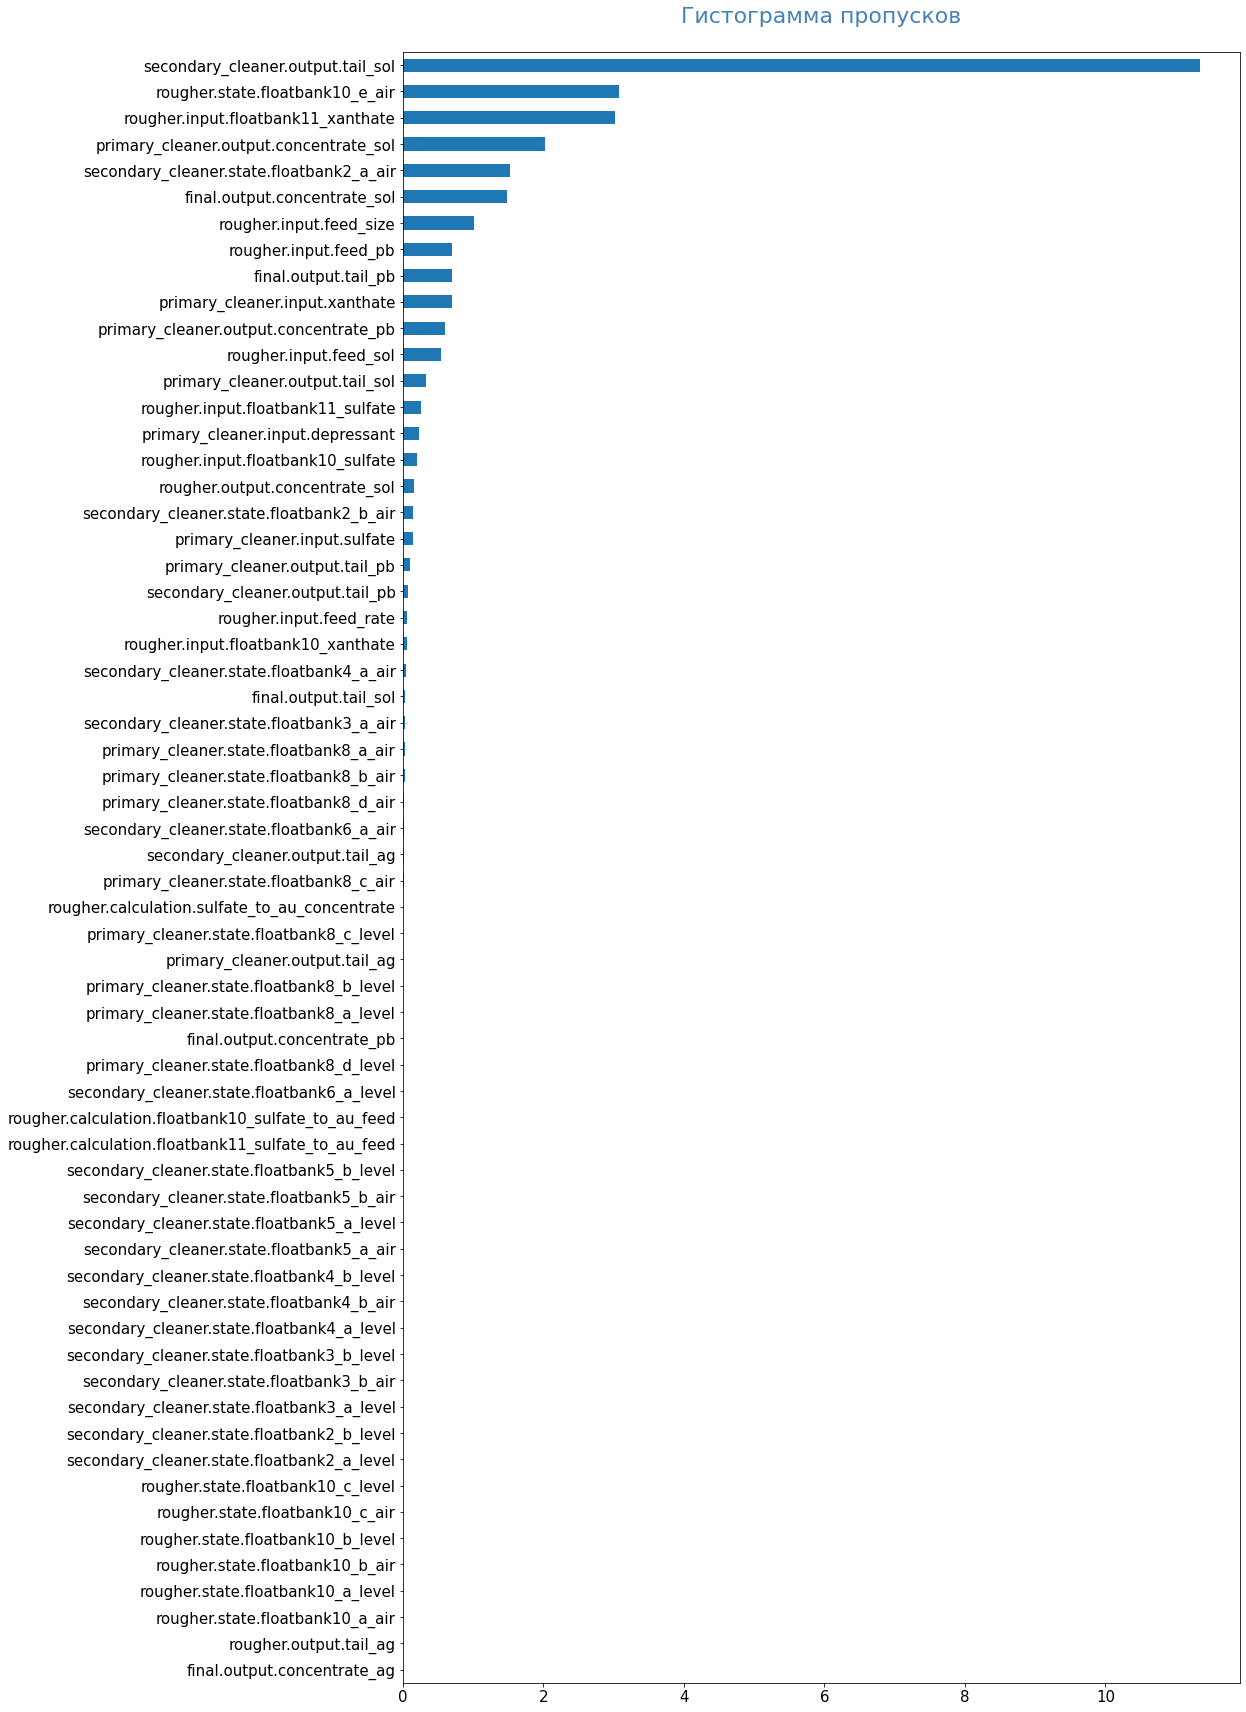

In [13]:
# функция построения гистограммы пропусков

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (15, 30), legend = False, fontsize = 15)
            .set_title('Гистограмма пропусков' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось')
        
pass_value_barh(train)

Заменим пропуски в данных, взяв их из full выборки. Возможно, так делать нельзя, но т.к. в задании вообще ничего о назначении выборок не сказано, то будем импровизировать:

In [14]:
train_na = train.loc[ train.isna().any(axis=1).values,     # выборка с пропусками
                       train.isna().any().values  ]          

for i in train_na:
    for j in train_na.index:
        if train.loc[j, i] != train.loc[j, i]:
            train.loc[j, i] = full.loc[j, i]            

In [15]:
train.isna().sum().sum()

817

Удалось заменить около 80% пропусков. Обработаем оставшиеся пропуски искусственными методами.

Размер датасета до обработки:

In [16]:
train.shape

(14149, 87)

Для начала удалим из датасета объекты, в которых пропущено более 5% признаков:

In [17]:
train.dropna(thresh=round(train.shape[1] * 0.95), inplace=True)
train.shape

(14143, 87)

Из датасета удалилось 6 объектов.

Т.к. в задании указано, что "*Соседние по времени параметры часто похожи*", то замену оставшихся пропусков произведем на смежное (предыдущее значение) значение. На всякий случай отсортируем таблицу по столбцу `date`:

In [18]:
train = train.sort_values(by='date').fillna(method='ffill')
train.isna().sum().sum()    # check

0

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Верно!👍:\
</b> Верное решение по обработке пропусков, в признаках их не много. Все наблюдения представляют собой последовательные измерения, заполнить пропуски можно методами `pandas`: `ffill`/ `bfill`/ `interpolate` , это вполне уместно.\
Хочу посоветовать тебе статью, которая рассматривает разные способы обработки пропусков, выделяет их плюсы и минусы, думаю, тебе может быть интересно: https://loginom.ru/blog/missing 

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14143 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14143 non-null  object 
 1   final.output.concentrate_ag                         14143 non-null  float64
 2   final.output.concentrate_pb                         14143 non-null  float64
 3   final.output.concentrate_sol                        14143 non-null  float64
 4   final.output.concentrate_au                         14143 non-null  float64
 5   final.output.recovery                               14143 non-null  float64
 6   final.output.tail_ag                                14143 non-null  float64
 7   final.output.tail_pb                                14143 non-null  float64
 8   final.output.tail_sol                               14143 non-null  float64


In [20]:
train.describe().round()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14143.0,14143.0,14143.0,14143.0,14143.0,14143.0,14143.0,14143.0,14143.0,14143.0,...,14143.0,14143.0,14143.0,14143.0,14143.0,14143.0,14143.0,14143.0,14143.0,14143.0
mean,5.0,10.0,9.0,44.0,67.0,10.0,3.0,11.0,3.0,133.0,...,20.0,-479.0,15.0,-460.0,17.0,-484.0,13.0,-484.0,20.0,-507.0
std,1.0,2.0,3.0,5.0,10.0,2.0,1.0,3.0,1.0,39.0,...,6.0,51.0,5.0,59.0,6.0,38.0,6.0,39.0,6.0,37.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,-800.0,0.0,-800.0,-0.0,-797.0,1.0,-800.0,0.0,-809.0
25%,4.0,9.0,7.0,43.0,63.0,8.0,2.0,9.0,2.0,107.0,...,15.0,-501.0,12.0,-500.0,11.0,-500.0,9.0,-500.0,15.0,-501.0
50%,5.0,10.0,9.0,45.0,67.0,9.0,3.0,11.0,3.0,133.0,...,20.0,-500.0,15.0,-499.0,18.0,-500.0,12.0,-500.0,20.0,-500.0
75%,6.0,11.0,10.0,46.0,72.0,11.0,3.0,12.0,3.0,160.0,...,25.0,-478.0,20.0,-400.0,21.0,-488.0,18.0,-456.0,25.0,-500.0
max,16.0,17.0,18.0,53.0,100.0,20.0,6.0,22.0,8.0,250.0,...,30.0,-245.0,24.0,-145.0,44.0,-275.0,28.0,-182.0,32.0,-104.0


#### Тестовая выборка

Кол-во пропусков в датасете:

In [21]:
test.isna().sum().sum()

90

В модель необходимо подавать данные без пропусков. Их кол-во мало, удалим их:

In [22]:
test.dropna(inplace=True)

test.isna().sum().sum()   # check

0

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
    
    
Данные подготовили, приступаем к анализу данных)
    
Для интереса, оставляю тебе ссылку, по флотации руды: https://www.youtube.com/watch?v=BY9d1MC6qLs и 

https://www.youtube.com/watch?v=qYuGEjR8ZKw&t=13s


## Исследовательский анализ данных

### Концентрация металлов (Au, Ag, Pb) на различных этапах очистки  


In [23]:
color = ['r', 'b', 'g', 'y', 'm', 'c', 'k']    # цвета для графиков

In [24]:
def concentrate(met):
    
    lst=[ 'rougher.input.feed_' + met,
          'rougher.output.concentrate_' + met,
          'primary_cleaner.output.concentrate_' + met,
          'final.output.concentrate_' + met ]
    
    color_shuffle = shuffle(color)
    
    fig, (*box, hist) = plt.subplots(nrows=len(lst)+1, 
                                     sharex=True, 
                                     figsize=(18, 12), 
                                     gridspec_kw={'height_ratios': [1, 1, 1, 1, 8]})
    
    plt.xlabel(f'Концентрация {met}', fontsize=20)
    plt.xticks(fontsize=15)
    plt.ylabel(' ')
    plt.yticks(fontsize=15)
    plt.grid('on')

    tmp = pd.DataFrame(columns=['Этап', 'Медиана', 'Среднее', 'Диапазон'])  # для таблицы результатов


    for n, i in enumerate(lst):
        tmp.loc[len(tmp)] = [i[:i.find('.output')],
                             train[i].median().round(2),
                             train[i].mean().round(2),
                             f'{train[i].min().round(2)} - {train[i].max().round(2)}']
        
        sns.histplot(data=train, ax=hist, x=i, bins=100, color=color_shuffle[n])

        sns.boxplot(data=train, ax=box[n], x=i, color=color_shuffle[n])
        
    plt.legend(lst, fontsize=15, handlelength=2)

    
    return tmp

,Этап,Медиана,Среднее,Диапазон
0,rougher.input.feed_a,7.65,7.87,0.01 - 13.13
1,rougher,19.95,19.44,0.0 - 28.15
2,primary_cleaner,33.23,32.39,0.0 - 45.93
3,final,44.87,44.01,0.0 - 52.76


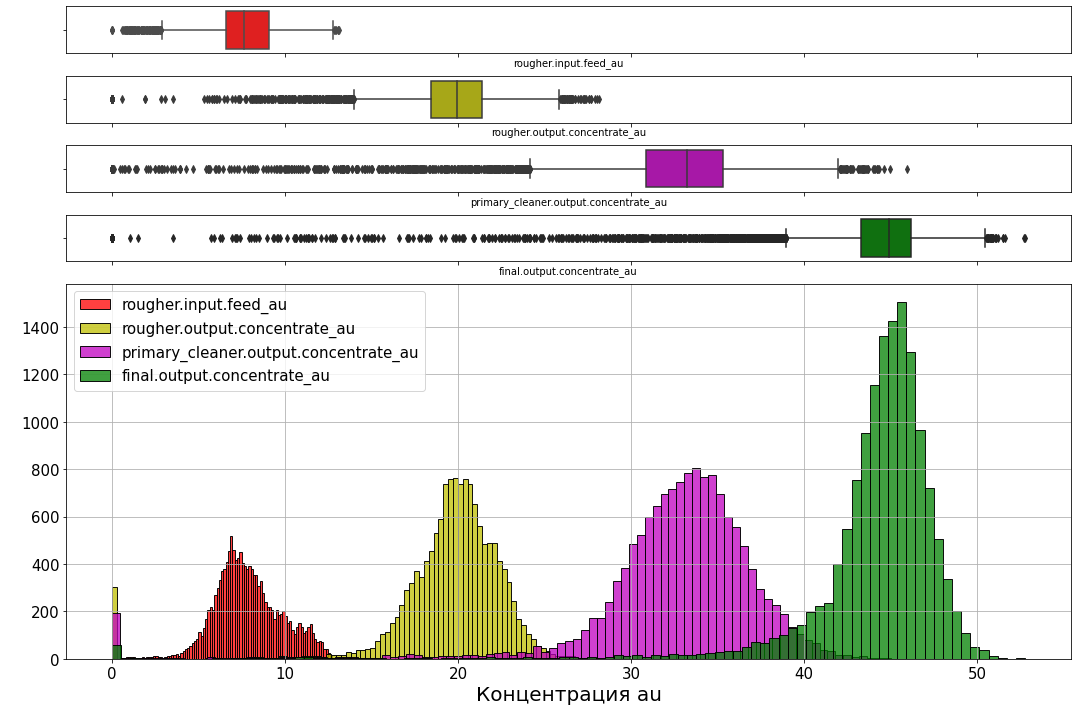

In [25]:
concentrate('au')

**Вывод:** Концентрация золота после флотации имеет более широкое распределение. Появилось большое кол-во выбросов. Среднее значение концентрации возрасло примерно в 1.7 раз. На этапе очистки распределение схожее, но смещено вправо, что говорит об увеличившихся значениях концентрации продукта. На финальном этапе распределение становится еще более узкое, при еще большем кол-ве выбросов. Всё это говорит о том, что качество выходного продукта значительно возросло, золото становится чище.

 <br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>
    
<b>На доработку🤔:</b>

</b> Мне интересно было изучить твои графики, практичный и красочный графический анализ. Тут еще ожидается показать на графиках и исходное сырье (rougher.input.feed_..). Добавь, пожалуйста. 

<br/>    
<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b></b> Добавил. Вывод чуть подредактировал.

<br/>    

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

,Этап,Медиана,Среднее,Диапазон
0,rougher.input.feed_a,8.16,8.58,0.01 - 14.6
1,rougher,11.75,11.77,0.0 - 21.73
2,primary_cleaner,8.23,8.20,0.0 - 16.08
3,final,4.99,5.14,0.0 - 16.0


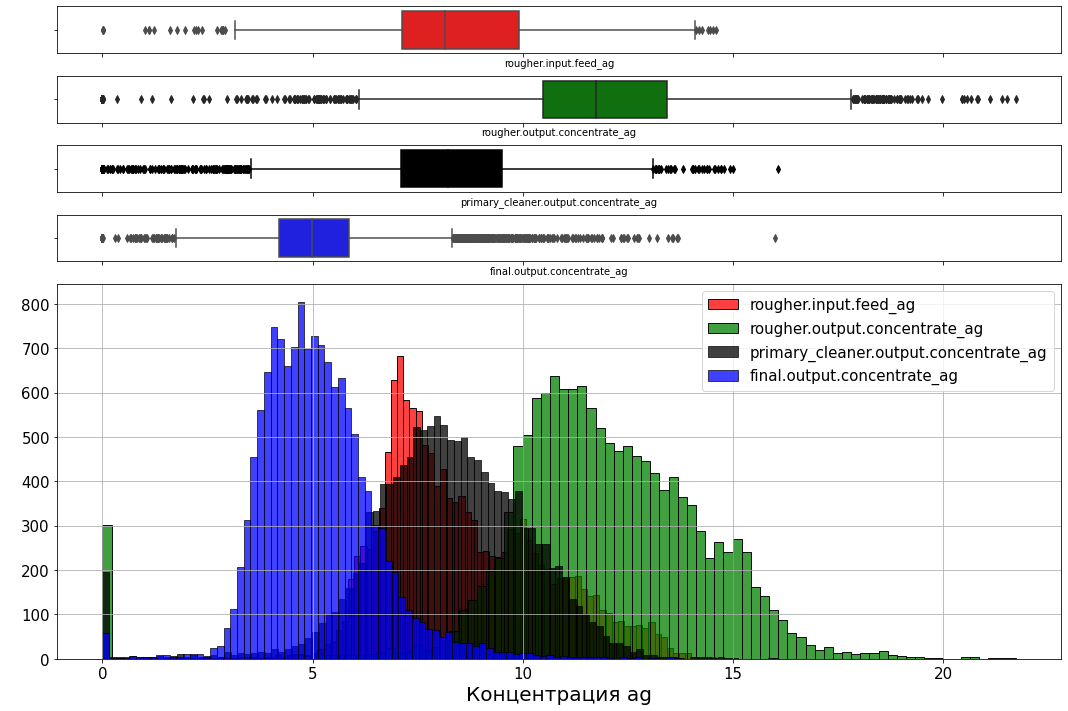

In [26]:
concentrate('ag')

**Вывод:** В случае с серебром ситуация обратная. На каждом этапе после выделения продукта, содержание серебра в руде уменьшается примерно в 1.5 раза. В тоже время распределение сужается, что говорит о более качественной очистке с каждым следующим этапом.

 <br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>
    
<b>На доработку🤔:</b>

</b> Мне интересно было изучить твои графики, практичный и красочный графический анализ. Тут еще ожидается показать на графиках и исходное сырье (rougher.input.feed_..). Добавь, пожалуйста. 

<br/>    
<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b></b> Добавил. Вывод чуть подредактировал.

<br/>    

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

,Этап,Медиана,Среднее,Диапазон
0,rougher.input.feed_p,3.43,3.53,0.01 - 7.14
1,rougher,7.76,7.66,0.0 - 13.62
2,primary_cleaner,9.93,9.58,0.0 - 17.08
3,final,10.30,10.13,0.0 - 17.03


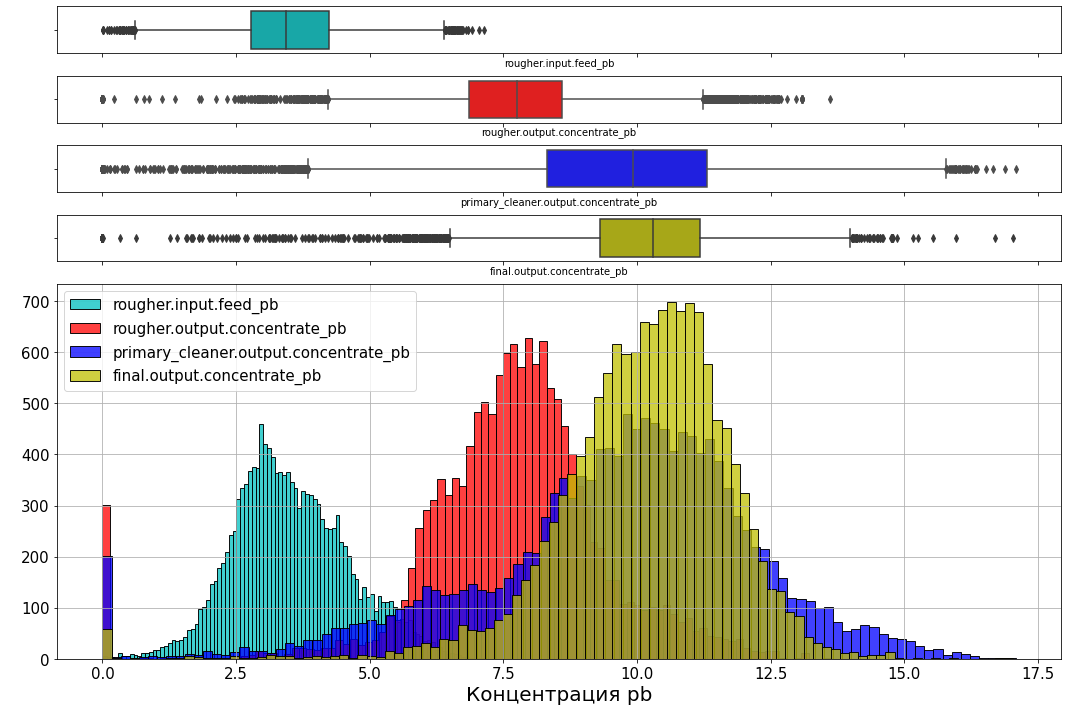

In [27]:
concentrate('pb')

**Вывод:** Концентрация свинца значительно увеличивается после выделения продукта. Характеризуется примерно равными состояниями на финальном этапе и этапе первичной очистки. На этапе флотации средняя концентрация свинца была примерно на треть меньше.

На всех трех графиках есть нулевые значения. Возможно, это вызвано ошибками в данных, например из-за сбоя в оборудовании. Но я не знаком с технолгическим процессом обработки золота, поэтому не могу сделать однозначный вывод о том, что нулевых значений концентрации быть не должно. Поэтому удалять объекты на данном этапе исследования считаю некорректным. Далее посмотрим на суммарные распределения и уже от этого сделаем вывод.

 <br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>
    
<b>На доработку🤔:</b>

</b> Мне интересно было изучить твои графики, практичный и красочный графический анализ. Тут еще ожидается показать на графиках и исходное сырье (rougher.input.feed_..). Добавь, пожалуйста. 

<br/>    
<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b></b> Добавил. Вывод чуть подредактировал.

<br/>    

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

###  Сравнение распределений размеров гранул сырья на обучающей и тестовой выборках

Размер гранул сырья обозначается *feed_size*. В данных есть 2 таких признака - `primary_cleaner.input.feed_size` и `rougher.input.feed_size`. Сравним их по гистограмме распределения. Т.к. выборка train имеет больший размер, сделаем из неё произвольную выборку размером с test выборку:

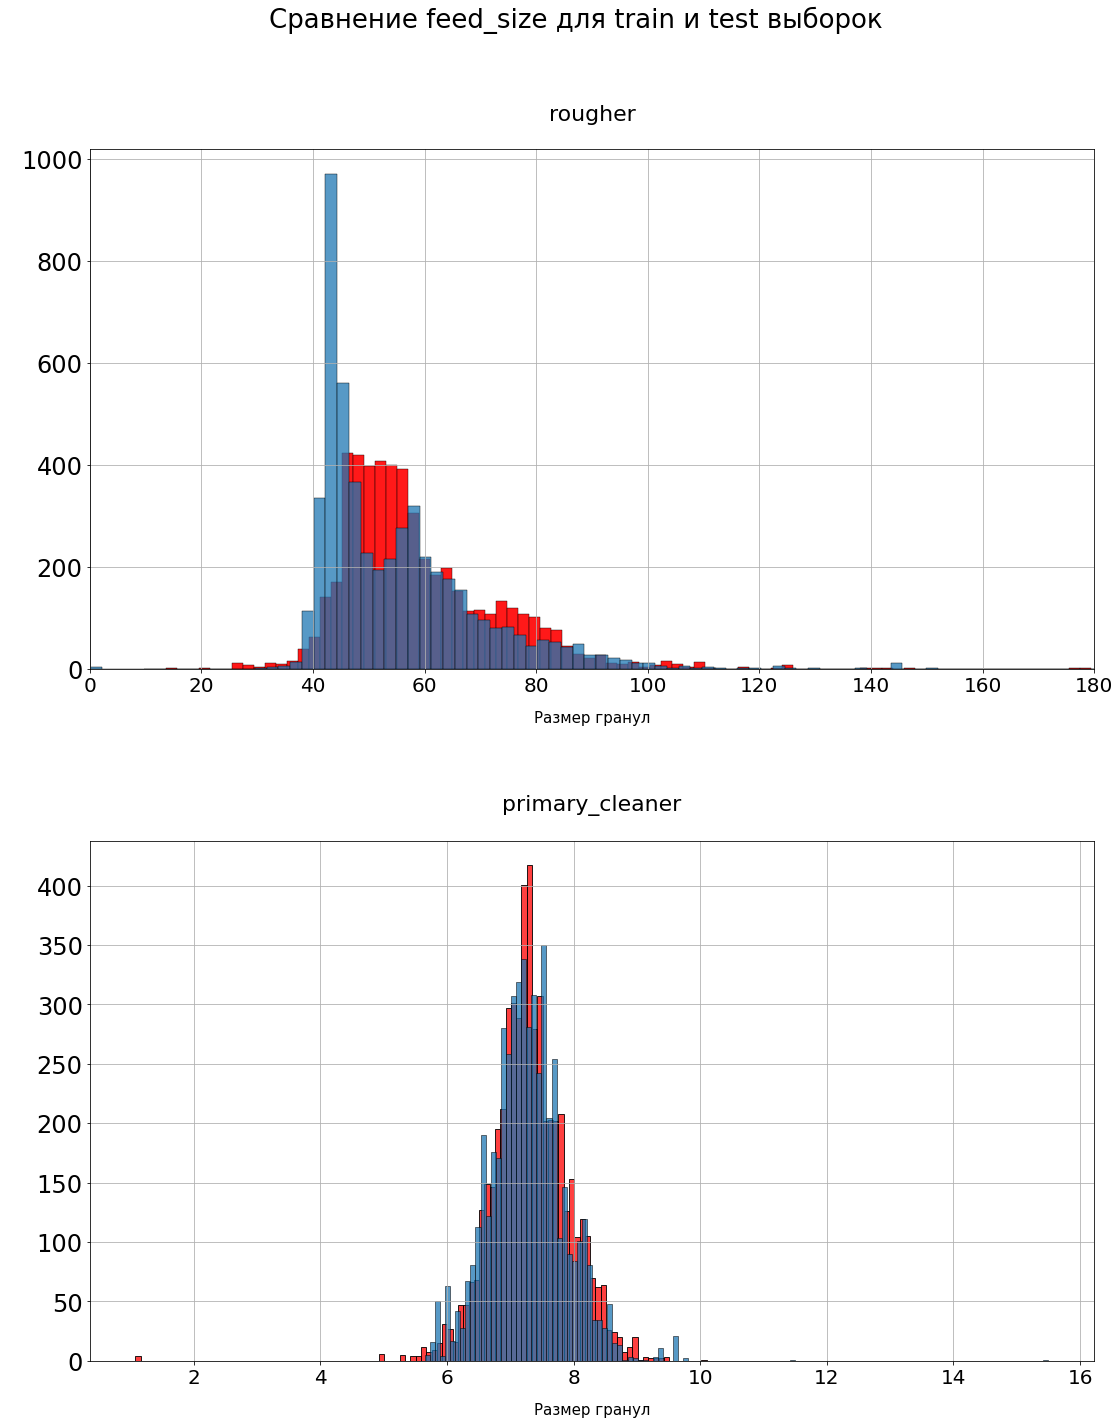

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(18, 22))

fig.suptitle('Сравнение feed_size для train и test выборок', fontsize=26)
fig.subplots_adjust(top=0.89, hspace=0.33)

train_sample = train.sample(test.shape[0])   # выборка из train


# график rougher
sns.histplot(ax=ax[0], 
             data=train_sample,
             x='rougher.input.feed_size', 
             color='r', 
             alpha=0.9)

sns.histplot(ax=ax[0], 
             data=test, 
             x='rougher.input.feed_size')

ax[0].set_title('rougher\n', fontsize=22)
ax[0].set_xlim([0, 180])



# график primary_cleaner
sns.histplot(ax=ax[1],
             data=train_sample, 
             x='primary_cleaner.input.feed_size', 
             color='r')

sns.histplot(ax=ax[1], 
             data=test,
             x='primary_cleaner.input.feed_size')

ax[1].set_title('primary_cleaner\n', fontsize=22)


# установка параметов для обоих графиков в цикле
for a in ax:
    a.set_xlabel('Размер гранул', fontsize=15, labelpad=15)
    a.set_ylabel(' ')
    a.tick_params(axis='x', labelsize=20)
    a.tick_params(axis='y', labelsize=24) 
    a.grid('on')
    

plt.show()

**Вывод:** Все выборки имеют распределение близкое к нормальному. Друг от друга распределения сильно не отличаются, за исключением выделяющегося большого кол-ва значений 40-45 test выборки на этапе флотации.

 <br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>
    
<b>На доработку🤔:</b>

Распределения примерно одинаковы. Для сравнения распределений выборок с разным размером лучше использовать графики плотности или kde вместо гистограмм частотности (по оси У доля относительно датасета вместо абсолютного количества). Наличие либо отсутствие разницы будет более очевидным.  Рекомендую тебе нормализовать гистограммы, например используя метод `sns.kdeplot`.

<br/>    
<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b></b> Хорошо, добавил ниже. А почему нельзя сделать как я сделал ранее - через выборку уменьшенного размера с sample из трейн? На мой взгляд результат получился схожий.

<br/>    

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> На урезанной выборке результат будет менее точный

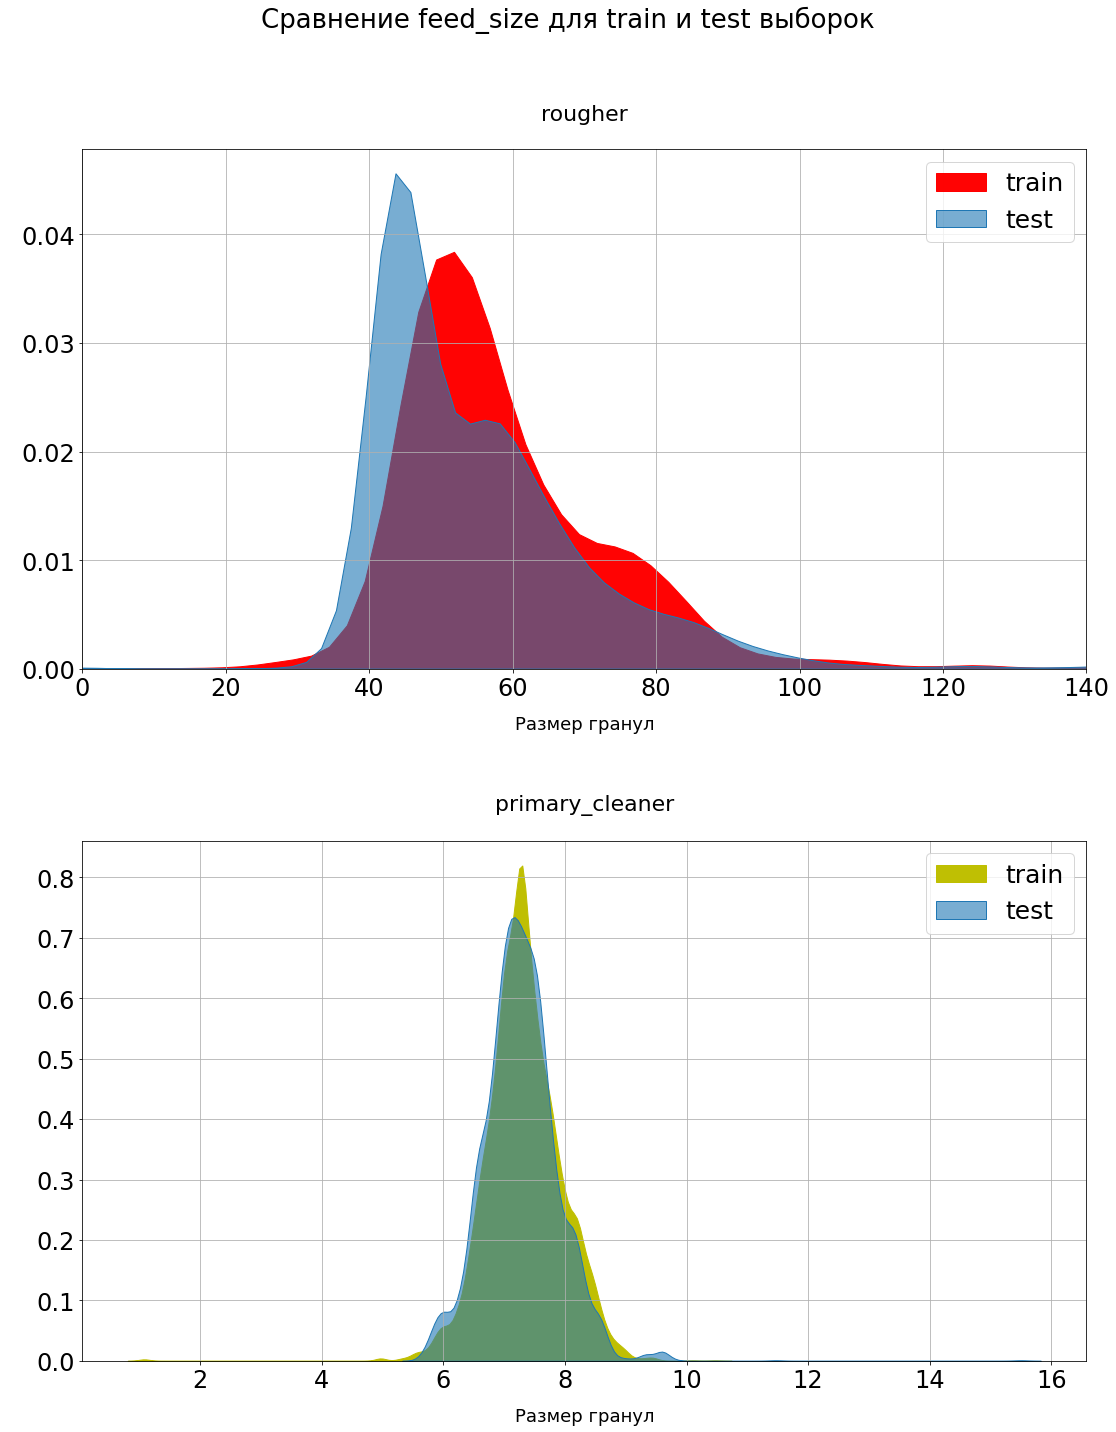

In [29]:
fig, ax = plt.subplots(2, 1, figsize=(18, 22))

fig.suptitle('Сравнение feed_size для train и test выборок', fontsize=26)
fig.subplots_adjust(top=0.89, hspace=0.33)



sns.kdeplot(train['rougher.input.feed_size'], 
            color='r',
            shade=True,
            alpha=0.99,
            ax=ax[0])

sns.kdeplot(test['rougher.input.feed_size'],
            shade=True,
            alpha=0.6,
            ax=ax[0])

ax[0].set_title('rougher\n', fontsize=22)
ax[0].set_xlim([0, 140])



# график primary_cleaner
sns.kdeplot(train['primary_cleaner.input.feed_size'], 
            color='y',
            shade=True,
            alpha=0.99,
            ax=ax[1])

sns.kdeplot(test['primary_cleaner.input.feed_size'],
            shade=True,
            alpha=0.6,
            ax=ax[1],)

ax[1].set_title('primary_cleaner\n', fontsize=22)


# установка параметов для обоих графиков в цикле
for a in ax:
    a.legend(['train', 'test'], fontsize=25)
    a.set_xlabel('Размер гранул', fontsize=18, labelpad=15)
    a.set_ylabel(' ')
    a.tick_params(axis='x', labelsize=24)
    a.tick_params(axis='y', labelsize=24) 
    a.grid('on')
    

plt.show()

### Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

In [30]:
def concentrate_sum(row):
    
    result = sum([train[f'{row}_{i}'] for i in ['au', 'ag', 'pb', 'sol']])
    
    fig, ax = plt.subplots(figsize=(16, 6))
    fig.suptitle(f'Суммарная концентрация {row}', fontsize=20)
    
    sns.histplot(result,
        bins=100, 
        color=np.random.choice(color))
    
    ax.grid('on')
    ax.set_ylabel(' ')
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    
    return result

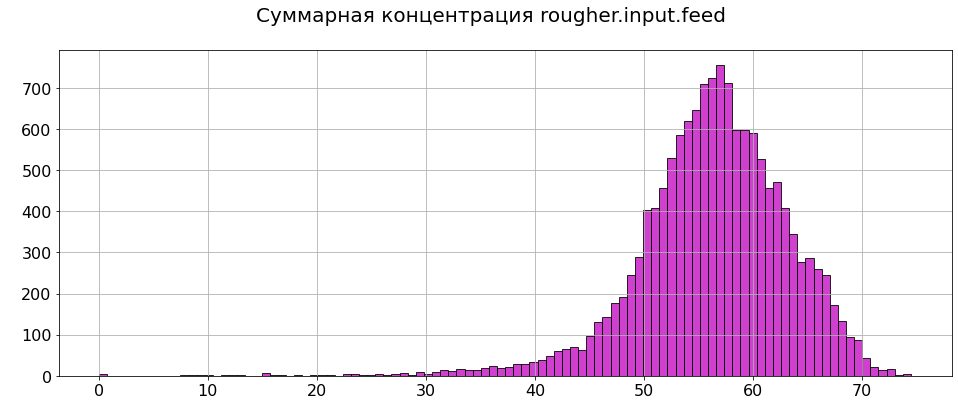

In [31]:
rougher_input_feed_sum = concentrate_sum('rougher.input.feed')

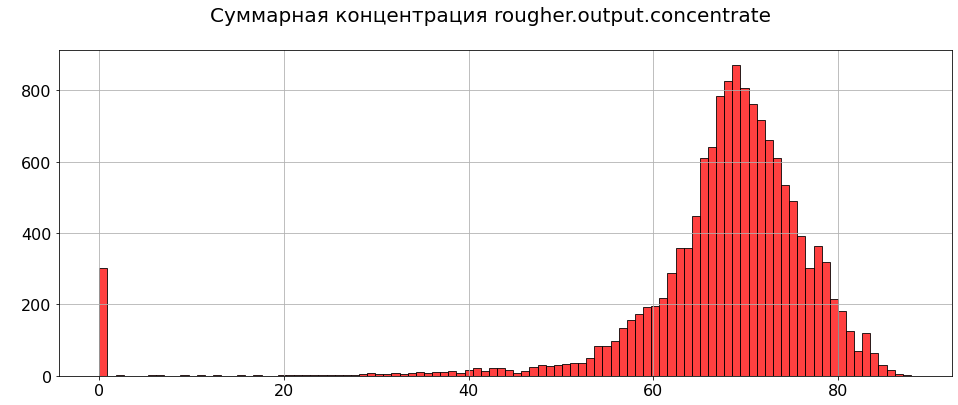

In [32]:
rougher_output_concentrate_sum = concentrate_sum('rougher.output.concentrate')

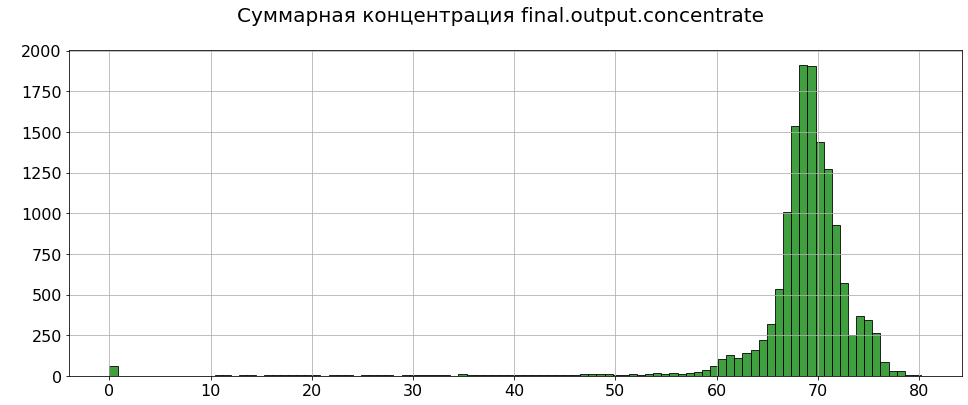

In [33]:
final_output_concentrate_sum = concentrate_sum('final.output.concentrate')

На гистограммах заметны нулевые суммарные значения. На этом этапе я всё же предположу, что это ошибочные данные. Удалим их из тренировочной выборки:

In [34]:
train.shape     # исходный размер

(14143, 87)

In [35]:
for i in [ rougher_input_feed_sum, 
           rougher_output_concentrate_sum, 
           final_output_concentrate_sum ]:
    
    train.drop(labels=i[i == 0].index, inplace=True, errors='ignore')
    
train.shape    # размер после удаления

(13789, 87)

**Вывод:** После удаления нулей датасет уменьшился еще на 354 объекта. Гистограммы показывают, что с каждым следующим этапом обработки распределение суммарной концентрации веществ сужается, а амплитуда значений растет.  

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 

Замечательно, суммарную концентрацию всех веществ на разных стадиях исследовали и нашли аномалии.
 
Ведь отдельно по каждому веществу они могут быть (не всегда же есть крупицы золота в руде), а вот суммарно - вряд ли (в руде хоть какие-то элементы, но будут). А если мы имеем ноль, значит большая вероятность неточности в измерениях.
    
Обучающую выборку нужно очистить от таких аномалий

##  Построение и обучение модели


На этом этапе обучим различные модели и оценим их качество кросс-валидацией.


### Функции для вычисления sMAPE

In [36]:
def smape(y_true, y_pred):
    
    result = 0
    for t, p in zip(y_true, y_pred):
        result += (abs(t - p) / ((abs(t) + abs(p))/2) * 100)
    
    return result / len(y_true)

In [37]:
def total_smape(smape_rougher, smape_final):
    
    return round(0.25 * smape_rougher + 0.75 * smape_final, 2)

<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>
    
<b>На доработку🤔:</b>
    
Формула для невзвешенной sMAPE верна. Тут еще предполагается написать функцию для вычисления итоговой sMAPE, добавь пожалуйста.

<br/>    
<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b></b> Добавил выше👍

<br/>    

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

### Обучение моделей

In [38]:
# модели

linear_model = LinearRegression()      # линейной регрессии
rfc_model =  RandomForestRegressor()   # случайного леса

In [39]:
# метрики качества

linear_smape = make_scorer(smape)                         # для регрессии
rfc_smape = make_scorer(smape, greater_is_better=False)   # для леса, т.к. нужна наименьшая метрика

#### rougher.output.recovery

Подготовим признаки для этапа флотации.

Согласно теории в задании, во флотационную установку подаётся смесь золотосодержащей руды и после обогащения получается черновой концентрат, который в дальнейшем будет проходить этапы очистки. Тогда выделять признаки будем следующим образом: для rougher - все признаки сырья, т.е. только этапа флотации, для final - все остальные признаки, т.е. признаки всех этапов очистки.

In [40]:
# выборка признаков с меткой rougher, которые есть и в train и в test
rougher_features_lst = ( set(train.iloc[:, train.columns.str.contains('rougher')]) &
                         set(test.columns)  )

rougher_features_train = train[rougher_features_lst]
rougher_target_train = train['rougher.output.recovery']

Посмотрим насколько зависимы между собой признаки, поскольку для линейных моделей мультиколлинеарность плоха:

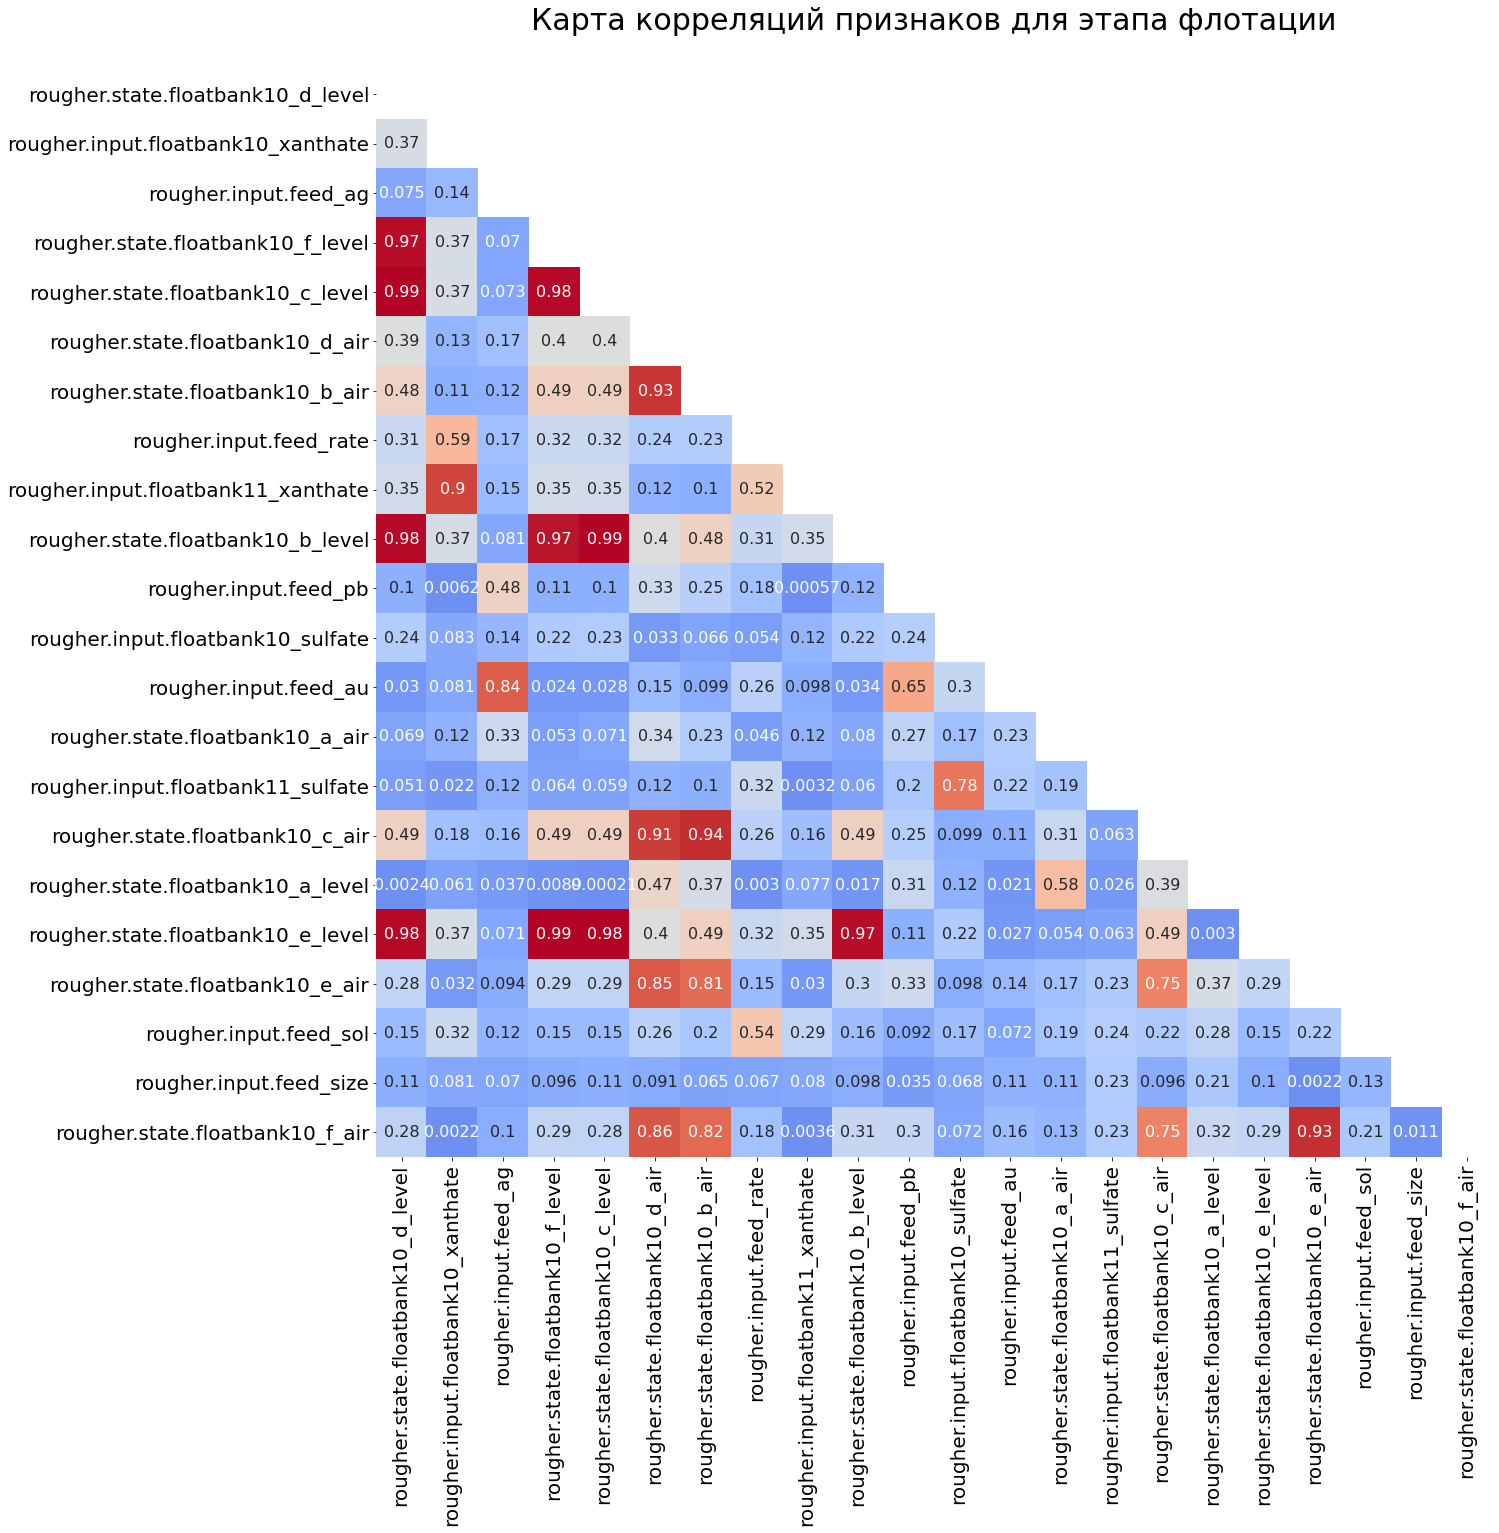

In [41]:
fig = plt.figure(figsize=(20, 20))

sns.heatmap( rougher_features_train.corr().abs(), 
             cmap="coolwarm", fmt='.2g', 
             cbar=False,
             center=0.4,
             annot=True, 
             annot_kws={'fontsize': 16},             
             mask=np.triu(rougher_features_train.corr()) )

plt.title('Карта корреляций признаков для этапа флотации'+ '\n', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

Удалим из списка признаков признаки с большим кол-вом высоких корреляций и перезапишем обучающую выборку:

In [42]:
rougher_features_lst = rougher_features_lst - set([ 'rougher.state.floatbank10_d_level', 
                                                    'rougher.state.floatbank10_e_level',
                                                    'rougher.state.floatbank10_b_level', 
                                                    'rougher.state.floatbank10_d_air',
                                                    'rougher.state.floatbank10_d_air',
                                                    'rougher.state.floatbank10_f_air'])

rougher_features_train = train[rougher_features_lst]

<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
        
- В нашем проекте мы сосредоточены на предсказаниях, поэтому проблема мультиколлинеарности, если она и есть, для нас не страшна, на предсказаниях она не сказывается (она влияет на значения коэффициентов линейной регрессии `.coef_`, для скоррелированных признаков они смещены, поэтому их интерпретация становится невозможной, но для нас сейчас это не имеет значения). Для отбора признаков вместо корреляции можно использовать функции feature selection уже после обучения моделей, то есть когда она с ними познакомилась и сама нам уже говорит, какие для нее важны, а какие не очень.
    
    
* Если хочется все-таки изучить корреляцию, то в нашем случае как минимум можно отбросить те признаки, которые не будут использоваться при обучении. Дополнительно предварительно можно отфильтровать матрицу, оставив только те признаки, по которым наблюдалась корреляция по модулю не меньше определенного значения.               
        
Функция corr() по дефолту считает корреляцию Пирсона. Но данный вид корреляции, во-первых, способен улавливать только линейные взаимосвязи, во-вторых, основан на предположениях, что переменные распределены нормально и однородны (представляют одну генеральную совокупность, не имеют выбросов), что далеко не всегда выполняется. Нарушение данных предположений может приводить к некорректной оценке степени корреляции, что будет вводить нас в заблуждение. 
        
Помимо корреляции Пирсона интересно также проверять <a href = 'https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7#:~:text=Phik%20(%F0%9D%9C%99k)%20is%20a%20new,a%20bivariate%20normal%20input%20distribution.'>Phik корреляцию</a>, у которой нет таких строгих предположений, и к тому же она способно улавливать нелинейные взаимосвязи, которые будут моделироваться в линейной регрессии немного иначе в зависимости от хараетера взаимосвязи.


<br/>    
<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b></b> Спасибо) Я в принципе здесь и рассматриваю только признаки для обучения, все остальные отбросил. Фильтровать не стал специально, чтоб была видна картина в целом. Признаков хоть и много, но хитмат вполне читабельный получается.

<br/>    

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

**Линейная регрессия**

In [43]:
scores = cross_val_score(linear_model, rougher_features_train, 
                         rougher_target_train, scoring=linear_smape, cv=5)

rougher_score = scores.mean()

print( '\nСреднее sMAPE модели линейной регрессии на этапе флотации =', 
        rougher_score.round(2) )


Среднее sMAPE модели линейной регрессии на этапе флотации = 6.67


<div class="alert alert-warning">
    <h2> Комментарий ревьюера <a class="tocSkip"> </h2>
    
<b>Некоторые замечания и рекомендации💡:</b> 
    
Хотя ты и не используешь тут стандартизацию признаков, оставлю для тебя полезную информацию. Для линейной регрессии, а также для моделей, основанных на деревьях, стандартизация либо нормализация данных перед обучением никак не влияет на качество предсказаний (<a href = 'https://www.baeldung.com/cs/normalization-vs-standardization'>ссылка</a>)
        
У моделей на основе деревьв принцип принятия решения завязан на относительности значений признаков, а она при стандартизации воздействию не подвергается. 
        
С линейными регрессиями чуть интереснее: стандартизация никак себя не проявит, поскольку все изменения переменной можно нивелировать за счет изменения коэффициента:  

$y = \alpha + \beta X$ - без стандартизации

$y = \alpha_{st} + \beta_{st} \frac{X-mean}{std} = (\alpha_{st} - \frac{\beta_{st}mean}{std}) + (\frac{\beta_{st}}{std}) X$ - со стандартизацией

При этом $\alpha = (\alpha_{st} - \frac{\beta_{st}mean}{std})$ и $\beta = (\frac{\beta_{st}}{std})$.

По ссылкам можно узнать, когда все-таки стандартизация крайне важна: <a href = 'https://www.listendata.com/2017/04/how-to-standardize-variable-in-regression.html'>ссылка 1</a>, <a href = 'https://www.statlect.com/fundamentals-of-statistics/linear-regression-with-standardized-variables'>ссылка 2</a>.

Преимущество, которое дает стандартизация для линейной регрессии, это то, что мы можем по величине полученных коэффициентов судить о важности соотвествующих признаков (больше коэффициент - больше значимость, важность необходима для регрессий с регуляризацией). Без стандартизации такая интерпретация невозможна, так как каждый коэффициент в себя включает еще и элемент балансировки масштаба своего признака. Но на качестве предсказаний это никак не отражается.
        
С другой стороны, применяя стандартизацию к признакам, нужно быть осторожным: если не использовать конвеерную обработку (<a href = 'https://stackoverflow.com/questions/51459406/how-to-apply-standardscaler-in-pipeline-in-scikit-learn-sklearn'>через пайплайн</a>), то утечка данных внутри кросс-валидации будет неизбежна. В пайплайнах реализуется стандартизация текущей тренировочной выборки, и распространение ее на текущую валидационную.

    Код ревьюера:
```python

        
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(StandardScaler(), ml_model)
cross_val_score(pipe, X, y)
```        
        
        
        

<br/>    
<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b></b> Спасибо большое за замечания. К сожалению, дедлайн уже в понедельник и я физически не успею добавить пайплайны в проект. Оставлю пока что так и вернусь к этому в следующем спринте)

<br/>    

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

**Случайный лес**

Полный перебор параметров был осуществлен мною заранее. Для упрощения проверки работы я поставил их в функцию и максимально сузил диапазон вокруг них.

In [44]:
%%time     

parametrs = { 'n_estimators': range(49, 50),       # 49
              'max_depth': range(5, 6),            # 5
              'min_samples_leaf': range(1, 2),     # 1
              'min_samples_split': range(3, 4),    # 3
              'random_state': [321] }


rougher_grid = GridSearchCV(rfc_model, parametrs, cv=5, scoring=rfc_smape, n_jobs=-1)

rougher_grid.fit(rougher_features_train, rougher_target_train)

print( '\nСреднее sMAPE модели случайного леса на этапе флотации =',
        -1 * rougher_grid.best_score_.round(2), '\n\n'  )


Среднее sMAPE модели случайного леса на этапе флотации = 6.54 


CPU times: user 18.7 s, sys: 58 ms, total: 18.7 s
Wall time: 18.8 s


In [45]:
# лучшие параметры модели

rougher_grid.best_params_

{'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 49,
 'random_state': 321}

**Вывод:** Для признака `rougher.output.recovery` наилучшее качество модели по метрике sMAPE показала модель случайного леса.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
        
Лучшую модель определили, хорошо)

#### final.output.recovery

По описаной выше методике выделм признаки для финального этапа:

In [46]:
# признаки для final

# выборка всех признаков, кроме rougher, которые есть и в train и в test
final_features_lst = ( set(train.iloc[:, ~train.columns.str.contains('rougher')]) &
                       set(test.columns) -
                       set(['date']) )

final_features_train = train[final_features_lst]

final_target_train = train['final.output.recovery']

Аналогичным образом проведем анализ признаков на мультиколлинеарность:

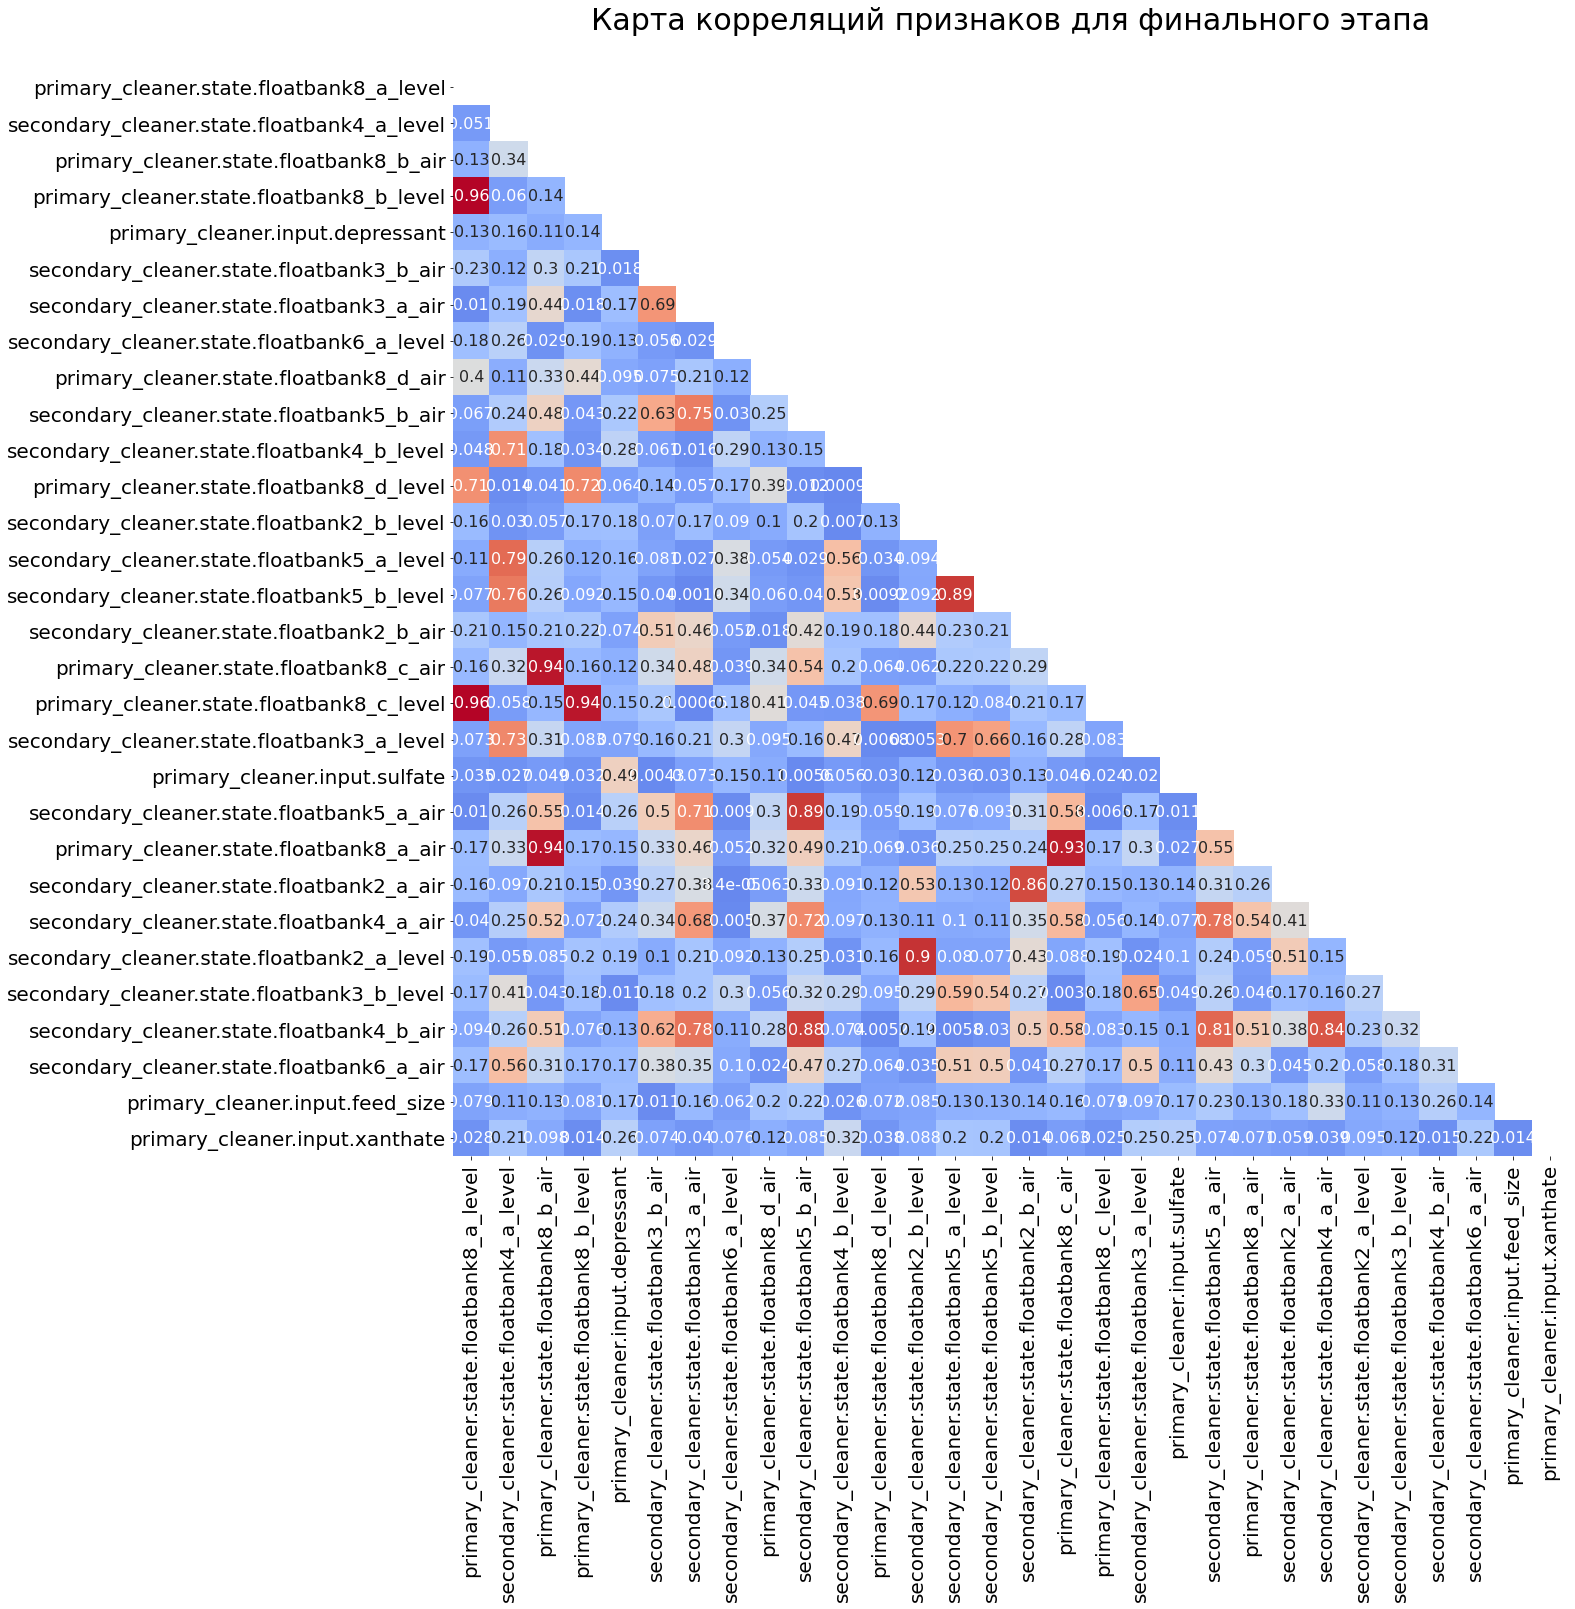

In [47]:
fig = plt.figure(figsize=(20, 20))

sns.heatmap( final_features_train.corr().abs(), 
             cmap="coolwarm", fmt='.2g', 
             cbar=False,
             center=0.4,
             annot=True, 
             annot_kws={'fontsize': 16},             
             mask=np.triu(final_features_train.corr()) 
               )

plt.title('Карта корреляций признаков для финального этапа'+ '\n', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

Удалим сильно коррелированные признаки:

In [48]:
final_features_lst = final_features_lst - set([ 'primary_cleaner.state.floatbank8_b_level',
                                                'secondary_cleaner.state.floatbank5_b_air',                                               
                                                'primary_cleaner.state.floatbank8_c_air',
                                                'primary_cleaner.state.floatbank8_a_air'  ])

final_features_train = train[final_features_lst]

**Линейная регрессия**

In [49]:
scores = cross_val_score(linear_model, final_features_train, 
                         final_target_train, scoring=linear_smape, cv=5)

final_score = scores.mean()

print( '\nСреднее sMAPE модели линейной регрессии на финальном этапе =', 
        final_score.round(2) )


Среднее sMAPE модели линейной регрессии на финальном этапе = 9.96


**Случайный лес**

Аналогично, заранее перебрал диапазон параметров, а в функцию по итогу занес наилучшие с наименьшим диапазоном.

In [50]:
%%time     

parametrs = { 'n_estimators': range(6, 7),        # 7
              'max_depth': range(1, 2),           # 1
              'min_samples_leaf': range(1, 2),    # 1
              'min_samples_split': range(2, 3),   # 2
              'random_state': [12] }

final_grid = GridSearchCV(rfc_model, parametrs, cv=5, scoring=rfc_smape, n_jobs=-1)

final_grid.fit(final_features_train, final_target_train)

print( '\nСреднее sMAPE модели случайного леса на финальном этапе =',
        -1 * final_grid.best_score_.round(2), '\n\n'  )


Среднее sMAPE модели случайного леса на финальном этапе = 9.93 


CPU times: user 872 ms, sys: 0 ns, total: 872 ms
Wall time: 955 ms


In [51]:
# лучшие параметры модели

final_grid.best_params_

{'max_depth': 1,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 6,
 'random_state': 12}

**Вывод:** Для признака `final.output.recovery` наилучшее качество модели по метрике sMAPE так же показала модель случайного леса.

<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
        
Лучшую модель определили, хорошо)

### Проверка на тестовой выборке

#### rougher.output.recovery

Т.к. в тестовой выборке нет целевого признака, возьмем его из выборки full:

In [52]:
test = test.merge(full[['rougher.output.recovery', 'final.output.recovery', 'date']],
                         how = 'inner', on= 'date')

In [53]:
# признаки

rougher_features_test = test[rougher_features_lst]

rougher_target_test = test['rougher.output.recovery']

<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>

    
<b>На доработку🤔:</b>

Порядок записей в выборках full и test отличается, поэтому такое присоединение некорректно. Чтобы операции присоединения таргетов были корректными, нужно  присоединять по столбцу `date`.  
    Код ревьюера:
```python

test = test.merge(full[['rougher.output.recovery', 'final.output.recovery', 'date']],
                         how = 'inner', on= 'date')
``` 
</div>

<br/>    
<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b></b> Сделано👍

<br/>    

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>

In [54]:
rougher_pred = rougher_grid.predict(rougher_features_test)

smape_rougher = smape(rougher_target_test, rougher_pred).round(2)

print('\nsMAPE этапа флотации на тестовой выборке =', smape_rougher) 


sMAPE этапа флотации на тестовой выборке = 8.11


#### final.output.recovery

Целевой признак так же возьмем из выборки full:

In [55]:
final_features_test = test[final_features_lst]

final_target_test = test['final.output.recovery']

In [56]:
final_pred = final_grid.predict(final_features_test)

smape_final = smape(final_target_test, final_pred).round(2)

print('\nsMAPE финального этапа на тестовой выборке =', smape_final) 


sMAPE финального этапа на тестовой выборке = 8.79


### Итоговая sMAPE

In [57]:
print('\nИтоговая sMAPE =', total_smape(smape_rougher, smape_final))


Итоговая sMAPE = 8.62


<div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b> 
        
Тестирование лучшей модели проведено правильно

<br/>
<div class="alert alert-block alert-danger">
<h2> Комментарий ревьюера <a class="tocSkip"></h2>
    
<b>На доработку🤔:</b>
    
В каждом проекте при оценке качества модели, имеет смысл сравнивать ее с константной моделью (к примеру, которая предсказывает медиану по таргету). И в наш проект важно добавить это сравнение.  Создавать константные модели можно либо вручную, либо воспользоваться готовым алгоритмом <a href='https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyRegressor.html'>DummyRegressor</a> из пакета `sklearn`.

<br/>    
<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

<b></b> Добавил ниже. Дамми модель предсказывает лушче, чем найденная мною. Получается вся работа в проекте проделана зря? :(

<br/>    

<div class="alert alert-success">
<h2> Комментарий ревьюера v.2 <a class="tocSkip"> </h2>

<b>Все отлично!👍:</b>
    
Дамми предсказывает хуже, метрика выше. Небольшой  "разбег" метрик допустим в этом проекте. Это может говорить либо о том, что еще есть смысл продолжить поиски "той самой" модели, либо структура данных такова, что ничего лучше константоной в принципе не найти, тогда в использовании более сложных ресурсозатратных моделей нет особого смысла.

Посмотрим что предскажет дамми модель:

In [58]:
dummy = DummyRegressor(strategy='median').fit(rougher_features_train, rougher_target_train)
predict_dummy = dummy.predict(rougher_features_test)
smape_rougher_dummy = smape(rougher_target_test, predict_dummy).round(2)

print('\nsMAPE dummy модели этапа флотации на тестовой выборке =', smape_rougher_dummy) 


sMAPE dummy модели этапа флотации на тестовой выборке = 8.38


In [59]:
dummy = DummyRegressor(strategy='median').fit(final_features_train, final_target_train)
predict_dummy = dummy.predict(final_features_train)
smape_final_dummy = smape(final_target_train, predict_dummy).round(2)

print('\nsMAPE dummy модели финального этапа на тестовой выборке =', smape_final_dummy) 


sMAPE dummy модели финального этапа на тестовой выборке = 10.17


In [60]:
print('\nИтоговая sMAPE =', total_smape(smape_rougher_dummy, smape_final_dummy))


Итоговая sMAPE = 9.72


## Выводы по проекту

В ходе проведенной работы были выполнены загрузка и обработка данных, проведен исследовательский анализ данных, построены и обучены модели, а так же расчитаны sMAPE («симметричное среднее абсолютное процентное отклонение») для моделей и итоговое sMAPE. 

Предварительный обзор данных показал, что:

+ данные состоят из 3 таблиц разного размера;
+ кол-во признаков - 87;
+ все признаки, кроме даты - числовые;
+ пропуски имеются во всех 3 датасетах;
+ явные дубликаты отсутствуют.
+ в тренировочных данных присутствует около 1.5% коррелирующих признаков.

В ходе предобработки было выполнено:

+ обработаны все пропуски в тренировочной выборке;
  + удалены объекты, в которых пропущено более 4 признаков;
  + удалены объекты с пропусками в столбцах, в которых доля пропусков меньше 0.5%;
  + оставшиеся пропуски были заменены на смежное предыдущее значение.

+ удалены все пропуски в тестовой выборке.

В ходе исследовательского анализа было выявлено:

+ концентрация золота после флотации имеет более широкое распределение, с увеличенным кол-вом выбросов. Среднее значение концентрации возрасло примерно в 1.7 раз. На финальном этапе распределение становится более узкое, при еще большем кол-ве выбросов. Среднее кол-во концентрации продукта суммарно увеличилось почти в 2 раза, что говорит о том, что качество выходного продукта возросло. Имеются нулевые значения;
+ в случае с серебром ситуация обратная. На каждом этапе содержание серебра в руде уменьшается примерно в 1.5 раза. В тоже время распределение сужается, что говорит о более качественной очистке с каждым следующим этапом. Кол-во нулевых значений примерно схожее с золотом;
+ концентрация свинца характеризуется примерно равными состояниями на финальном этапе и этапе первичной очистки. На этапе флотации средняя концентрация свинца была примерно на треть меньше;
+ распределение размеров гранул сырья на обучающей и тестовой выборках близкое к нормальному. Друг от друга распределения сильно не отличаются, за исключением выделяющегося большого кол-ва значений 40-45 test выборки на этапе флотации;
+ с каждым следующим этапом обработки распределение суммарной концентрации веществ сужается, а амплитуда значений растет.


Всего в ходе работы были протестированы следующие модели:

LR - LogisticRegression  
RFC - RandomForestClassifier

Метрика sMAPE на тренировочной выборке на кросс-валидации:

LR - 6.67 для флотации и 9.96 для финального этапа;  
RFC - 6.54 для флотации и 9.93 для финального этапа.

В результате работы лучшей моделью оказалась модель случайного леса RFC. Её метрики sMAPE на **тестовой** выборке:

8.11 для флотации и 8.79 для финального этапа.

**Итоговая sMAPE** = 8.62

<div style="border:solid Chocolate 2px; padding: 40px">


<h2> Итоговый комментарий ревьюера v.1 <a class="tocSkip"> </h2>    
    
  
У меня сложилось хорошее общее впечатление о проекте, тебе удалось неплохо справиться с таким объемным и сложным проектом. Молодец! Подготовлены данные для анализа, изучен каждый параметр. Все красиво визуализировано, построено несколько моделей регрессии и оценено их качество. Осмысленная аналитика и дельная модельная работа - многое удалось как надо)
    
Отмечу отдельные положительные моменты проекта🙂:
    
- в ходе проекта встречались функции, помогающие избавиться от дублирования кода;
- много красивых визуализаций в проекте и хорошая интерпретация;
- при обучении моделей использована кросс-валидация и поиск гиперпараметров.
    
Есть несколько моментов всего, на которые стоит ещё раз взглянуть, их я обзначил тебе в комментариях по ходу проекта. Предлагаю тебе доработать проект по моим комментариям, чтобы довести его до совершенства.

Если будут вопросы, обращайся, с удовольствием на них отвечу.  
</div>

<div style="border:solid Chocolate 2px; padding: 40px">


<h2> Итоговый комментарий ревьюера v.2 <a class="tocSkip"> </h2>    
    
     
  
Теперь почти идеально. Принимаю работу)
    
Если хочешь лучше разобраться в ML, то могу посоветовать тебе: 
    
- Открытый курс машинного обучения: https://habr.com/ru/company/ods/blog/322626/   
    
- Книжка от ШАД: https://academy.yandex.ru/handbook/ml/
    
- Также рекомендую лекции от Andrew Ng: https://www.youtube.com/watch?v=PPLop4L2eGk&list=PLLssT5z_DsK-h9vYZkQkYNWcItqhlRJLN
- Избежать утечки данных при кросс-валидации тебе поможет <a href="https://towardsdatascience.com/pipeline-columntransformer-and-featureunion-explained-f5491f815f">конвеерная обработка данных</a>.     
    
- Не все признаки приносят пользу при моделировании. Инструмент <a href="https://proglib.io/p/feature-selector">FeatureSelector</a> поможет тебе отобрать важные признаки и избавит от ручной обработки.  Также можешь посмотреть статью на <a href="https://www.kaggle.com/code/prashant111/comprehensive-guide-on-feature-selection/notebook">Kaggle</a>.    
    
    
В этом проекте были отработаны несколько моментов. А самый очевидный: заметно, что разность метрик качества (константной и нашей модели) -  не слишком большая. Такое расхождение метрик допустимо в этом проекте. Что тогда  для дальнейшего улучшения качества моделирования возможно тут пересмотреть?
Попробую описать для тебя:
1. Качество данных на входе модели машинного обучения: повторно оценить аномалии, пропуски, соответствие законам химии и физики, все ли правдоподобно?
2. Работа с моделями машинного обучения:
- Создание новых признаков для моделей, Features Engineering: возможно стоит обратиться к технологу производства и ещё раз пробежаться по бизнес-цепочке процесса.
- Отбор самих моделей машинного обучения и гиперпараметров.
    
3. Параметры производственного процесса, к примеру: температура сырья, скорость ленточного конвейера, и.т.п.
    

Если провести Анализ измерительных систем, или MSA, то можно разобраться в причинах неточности полученных с производства данных. Статистический анализ данных, или SPC, - тоже будет являться незаменимым помощником в решении нашей задачи.
    
Добавлю здесь, что цель нашего проекта достигнута, а именно пройдены важные этапы подготовки данных и построения модели для производства золота.
    
Успехов тебе в следующем спринте!
    
Рад был помочь тебе)
    
</div>

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке выполнения
- [ ]  Выполнен шаг 1: данные подготовлены
    - [ ]  Проверена формула вычисления эффективности обогащения
    - [ ]  Проанализированы признаки, недоступные в тестовой выборке
    - [ ]  Проведена предобработка данных
- [ ]  Выполнен шаг 2: данные проанализированы
    - [ ]  Исследовано изменение концентрации элементов на каждом этапе
    - [ ]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [ ]  Исследованы суммарные концентрации
- [ ]  Выполнен шаг 3: построена модель прогнозирования
    - [ ]  Написана функция для вычисления итогового *sMAPE*
    - [ ]  Обучено и проверено несколько моделей
    - [ ]  Выбрана лучшая модель, её качество проверено на тестовой выборке